# 04-reg-sub-eq.ipynb

Processing includes:
- image registration with `phase_cross_correlation`
- liquid subtraction
- adaptive histogram equalization

In [2]:
import imageio.v3 as iio
import matplotlib.pyplot as plt
import napari
import numpy as np
from pathlib import Path
from skimage import exposure, filters, registration, util
# Local imports
import helpers

In [26]:
# Open napari window
viewer = napari.Viewer()

Note: You may need to put an "r" before the image directory path if the string contains backslashes. Don't forget commas between parameters!

In [4]:
img_dir = Path(
        r'X:\Radiography Drive\2013-11_APS'
        r'\Clarke_2013_November\048_Sn27Bi_100')
img_start = 352
img_stop = 372
img_step = 1
imgs = helpers.get_imgs(
    img_dir,
    img_start=img_start,
    img_stop=img_stop,
    img_step=img_step,
    # n_imgs=20,
    print_nums=True
)


Loading 20 images...
Images loaded:
['0: 352', '1: 353', '2: 354', '3: 355', '4: 356', '5: 357', '6: 358', '7: 359', '8: 360', '9: 361', '10: 362', '11: 363', '12: 364', '13: 365', '14: 366', '15: 367', '16: 368', '17: 369', '18: 370', '19: 371']


<Image layer 'imgs-352-372-1' at 0x21f50d3a5b0>

In [28]:
viewer.add_image(imgs, name=f'imgs-{img_start}-{img_stop}-{img_step}')

<Image layer 'imgs-352-372-1' at 0x21f024c1dc0>

In [5]:
# Convert image to float before calculations
imgs_float = util.img_as_float(imgs)
# Calc liquid-subtracted images without offset/drift-correction
imgs_sub = np.zeros_like(imgs_float[-1, :, :])
imgs_sub = imgs_float[:, :] - imgs_float[0, :, :]
# Calculate max offset between first and last image
offset, error, diffphase = registration.phase_cross_correlation(
        imgs_float[0, :, :], imgs_float[-1, :, :])
max_offset_r = int(offset[0])
max_offset_c = int(offset[1])
# Calc liquid-subtracted images with offset/drift-correction
imgs_sub_crctd = np.zeros(
        (imgs_float.shape[0],
         imgs_float.shape[1] - abs(max_offset_r),
         imgs_float.shape[2] - abs(max_offset_c)))
# Iterate through each image and perform subtraction adjusting for offset/drift
for i in range(imgs_float.shape[0]):
    offset, error, diffphase = registration.phase_cross_correlation(
            imgs_float[0, :, :], imgs_float[i, :, :])
    offset_r = int(offset[0])
    offset_c = int(offset[1])
    img_liq = imgs_float[
            0,
            : imgs_float.shape[1] - abs(max_offset_r),
            : imgs_float.shape[2] - abs(max_offset_c)]
    img_i = imgs_float[
            i,
            abs(offset_r) : imgs.shape[1] - (abs(max_offset_r) - abs(offset_r)),
            abs(offset_c) : imgs.shape[2] - (abs(max_offset_c) - abs(offset_c))]
    imgs_sub_crctd[i, :, :] = img_i - img_liq
viewer.add_image(imgs_sub)
viewer.add_image(imgs_sub_crctd)

<Image layer 'imgs_sub_crctd' at 0x21f54795f40>

## Adaptive histogram equalization

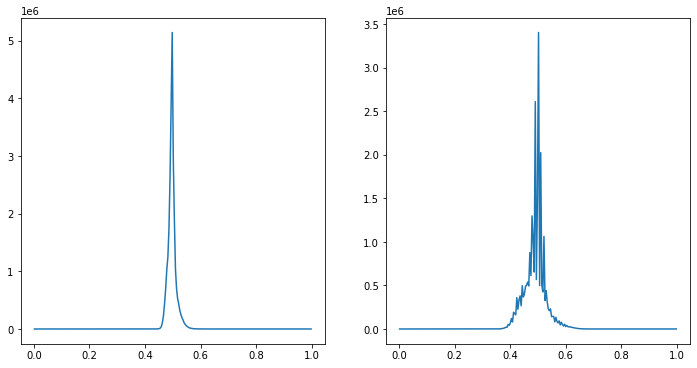

<Image layer 'imgs_sub_adapteq [1]' at 0x21f022125e0>

In [19]:
imgs_sub_0to1 = exposure.rescale_intensity(
        imgs_sub_crctd, in_range='image', out_range=(0, 1))
vals_sub_0to1, bins_sub_0to1 = exposure.histogram(imgs_sub_0to1)
imgs_sub_adapteq = exposure.equalize_adapthist(imgs_sub_0to1)
vals_sub_adapteq, bins_sub_adapteq = exposure.histogram(
        imgs_sub_adapteq)
fig, axes = plt.subplots(1, 2, figsize=(12, 6))
ax = axes.ravel()
ax[0].plot(bins_sub_0to1, vals_sub_0to1)
ax[1].plot(bins_sub_adapteq, vals_sub_adapteq)
plt.show()
viewer.add_image(imgs_sub_adapteq)

## Intenisty clipping

In [25]:
low, high = np.percentile(imgs_sub_adapteq, (0.1, 99.9))
imgs_sub_adapteq_clpd = np.clip(imgs_sub_adapteq, low, high)
viewer.add_image(
        imgs_sub_adapteq_clpd,
        name=f'clipped: [{round(low, 3)}, {round(high, 3)}]')

<Image layer 'clipped: [0.38, 0.638]' at 0x21f02069cd0>

## Beam correction

In [12]:
beam_img_dir = Path(
        r"X:\Radiography Drive\2013-11_APS"
        r"\Clarke_2013_November\036_MonoBeam")
beam_imgs = [
        iio.imread(path) for path in beam_img_dir.glob('*.tif')
        if 'AVG' not in path.stem]
beam_imgs = np.stack(beam_imgs)
avg_beam_img = np.mean(beam_imgs, axis=0)
avg_beam_img = exposure.rescale_intensity(
        avg_beam_img, in_range=np.uint16, out_range=float)


<Image layer 'avg_beam float' at 0x21f56b764c0>

In [27]:
viewer.add_image(avg_beam_img, name='avg_beam float')

<Image layer 'avg_beam float' at 0x21f02499520>

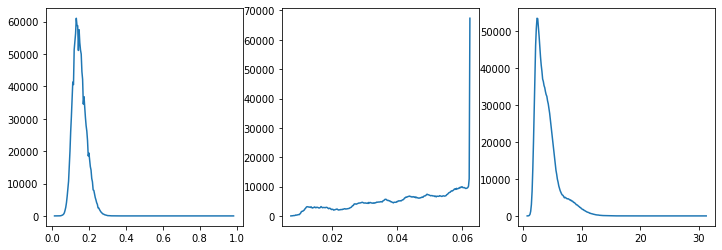

<Image layer 'img_norm' at 0x21f01a92cd0>

In [36]:
imgs_float = exposure.rescale_intensity(
        imgs, in_range='image', out_range=(0, 1))
img_float = imgs_float[0, :, :]
vals_img, bins_img = exposure.histogram(
        img_float)
vals_avg_beam, bins_avg_beam = exposure.histogram(
        avg_beam_img)
img_norm = img_float / avg_beam_img
vals_img_norm, bins_img_norm = exposure.histogram(
        img_norm)
fig, axes = plt.subplots(1, 3, figsize=(12, 4))
ax = axes.ravel()
ax[0].plot(bins_img, vals_img)
ax[1].plot(bins_avg_beam, vals_avg_beam)
ax[2].plot(bins_img_norm, vals_img_norm)
plt.show()
viewer.add_image(img_norm)

In [18]:
avg_beam_cropped = avg_beam_img[
        : imgs_float.shape[1] - abs(max_offset_r),
        : imgs_float.shape[2] - abs(max_offset_c)]
imgs_sub_beam_crctd = imgs_sub_crctd / avg_beam_cropped * imgs_sub_crctd.mean()
viewer.add_image(imgs_sub_beam_crctd)

<Image layer 'imgs_sub_beam_crctd [1]' at 0x21f020697f0>

## Compare median-filtered images

In [11]:
# Median filter images before converting to float
imgs_med = filters.median(imgs)
# Convert image to float before calculations
imgs_float = util.img_as_float(imgs_med)
# Calc liquid-subtracted images without offset/drift-correction
imgs_med_sub = np.zeros_like(imgs_float[-1, :, :])
imgs_med_sub = imgs_float[:, :] - imgs_float[0, :, :]
# Calculate max offset between first and last image
offset, error, diffphase = registration.phase_cross_correlation(
        imgs_float[0, :, :], imgs_float[-1, :, :])
max_offset_r = int(offset[0])
max_offset_c = int(offset[1])
# Calc liquid-subtracted images with offset/drift-correction
imgs_med_sub_crctd = np.zeros(
        (imgs_float.shape[0],
         imgs_float.shape[1] - abs(max_offset_r),
         imgs_float.shape[2] - abs(max_offset_c)))
# Iterate through each image and perform subtraction adjusting for offset/drift
for i in range(imgs_float.shape[0]):
    offset, error, diffphase = registration.phase_cross_correlation(
            imgs_float[0, :, :], imgs_float[i, :, :])
    offset_r = int(offset[0])
    offset_c = int(offset[1])
    img_liq = imgs_float[
            0,
            : imgs_float.shape[1] - abs(max_offset_r),
            : imgs_float.shape[2] - abs(max_offset_c)]
    img_i = imgs_float[
            i,
            abs(offset_r) : imgs.shape[1] - (abs(max_offset_r) - abs(offset_r)),
            abs(offset_c) : imgs.shape[2] - (abs(max_offset_c) - abs(offset_c))]
    imgs_med_sub_crctd[i, :, :] = img_i - img_liq
viewer.add_image(imgs_med_sub)
viewer.add_image(imgs_med_sub_crctd)

<Image layer 'imgs_med_sub_crctd' at 0x21f0204b490>

In [8]:
def save_as_pngs(save_dir, imgs):
    save_dir = Path(save_dir)
    if not save_dir.is_dir():
        save_dir.mkdir()
    else:
        raise ValueError(f'Directory already exists: {save_dir}')
    exp_name = save_dir.stem
    n_imgs = imgs.shape[0]
    n_digits = len(str(n_imgs))
    for i in range(n_imgs):
        iio.imwrite(
                Path(save_dir) / f'{exp_name}_{str(i).zfill(n_digits)}.png',
                imgs[i, :, :])

In [9]:
if False:
    save_dir = Path(
        r'C:\Users\gusb\Research\aps-directional'
        r'\results\048_Sn27Bi_100-352-372-1_med-filt_liq-sub_adapt-eq')
    save_as_pngs(save_dir, imgs_med_sub_0to1_adapteq_uint8)

In [10]:
if False:
    helpers.save_as_gif(
        (
            f'results/{img_dir.stem}-{img_start}-{img_stop}-{img_step}'
            f'_beam-norm_liq-sub.gif'
        ),
        imgs_sub_uint_resc,
        equalize_hist=False,
        fps=5
    )